In [2]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# load the excel sheet into a Dataframe
xls = pd.ExcelFile("UW_Churn_Pred_Data.xls")
print(f"Sheet Names: {xls.sheet_names}")

Sheet Names: ['Data', 'Legend', 'N10', 'B30 Pro']


In [9]:
# Load the B30 Pro sheet
b30_pro = pd.read_excel(xls, sheet_name="B30 Pro")

In [ ]:
# Display size of the data
print(f"B30 Pro Shape: {b30_pro.shape}")

B30 Pro Shape: (3142, 19)


In [12]:
# Display basic info about the data
print(b30_pro.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   model                      3142 non-null   object 
 1   sim_info                   3142 non-null   object 
 2   register_email             3142 non-null   bool   
 3   interval_date              3142 non-null   object 
 4   last_boot_date             3142 non-null   object 
 5   active_date                3142 non-null   object 
 6   last boot - interval       3142 non-null   float64
 7   last boot - active         3142 non-null   float64
 8   return - activate          3142 non-null   float64
 9   Return date                3142 non-null   object 
 10  Channel                    3142 non-null   object 
 11  Type                       3142 non-null   object 
 12  Warranty                   3142 non-null   object 
 13  Analysis and Verification  3142 non-null   objec

In [ ]:
# check for missing values
print(f"Missing Values:\n{b30_pro.isnull().sum()}")

Missing Values:
model                        0
sim_info                     0
register_email               0
interval_date                0
last_boot_date               0
active_date                  0
last boot - interval         0
last boot - active           0
return - activate            0
Return date                  0
Channel                      0
Type                         0
Warranty                     0
Analysis and Verification    0
Defect / Damage type         0
Responsible Party            0
Spare Parts Usage            0
Final Status                 0
Churn Flag                   0
dtype: int64


In [14]:
# check for duplicates
duplicates = b30_pro.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


Churn Flag Distribution:
Churn Flag
0    3072
1      70
Name: count, dtype: int64


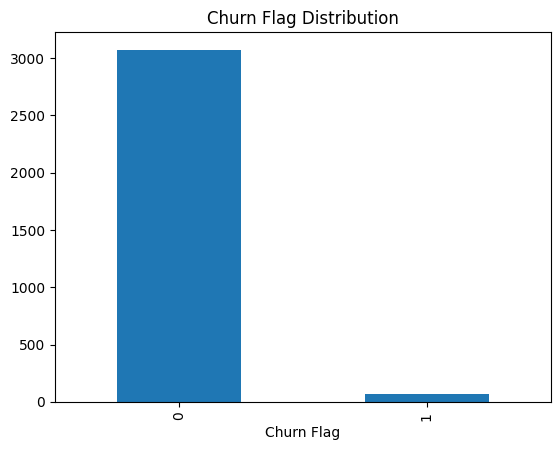

In [15]:
# visualize the distribution of the 'Churn Flag' => check for class imbalance
if 'Churn Flag' in b30_pro.columns:
    churn_counts = b30_pro['Churn Flag'].value_counts()
    print(f"Churn Flag Distribution:\n{churn_counts}")
    churn_counts.plot(kind='bar', title='Churn Flag Distribution')
    plt.show()

This shows that the distribution of the "Churn Flag" column is imbalanced!

In [ ]:
# Separate churned and non-churned records
churned = b30_pro[b30_pro['Churn Flag'] == 1]
non_churned = b30_pro[b30_pro['Churn Flag'] == 0]

# Plot the distribution of a feature for churned vs non-churned customers
def plot_feature_distribution(data, feature, churned_data, non_churned_data):
    # Plot the distributions
    plt.figure(figsize=(12, 6))
    sns.histplot(churned_data[feature], color='red', label='Churned', kde=True, stat='density', bins=30)
    sns.histplot(non_churned_data[feature], color='blue', label='Non-Churned', kde=True, stat='density', bins=30)
    plt.title(f'Distribution of {feature}: Churned vs Non-Churned')
    plt.legend()
    plt.show()

In [ ]:
# List of numerical features (seen from the data info)
numerical_features = ['last boot - interval', 'last boot - active', 'return - activate']

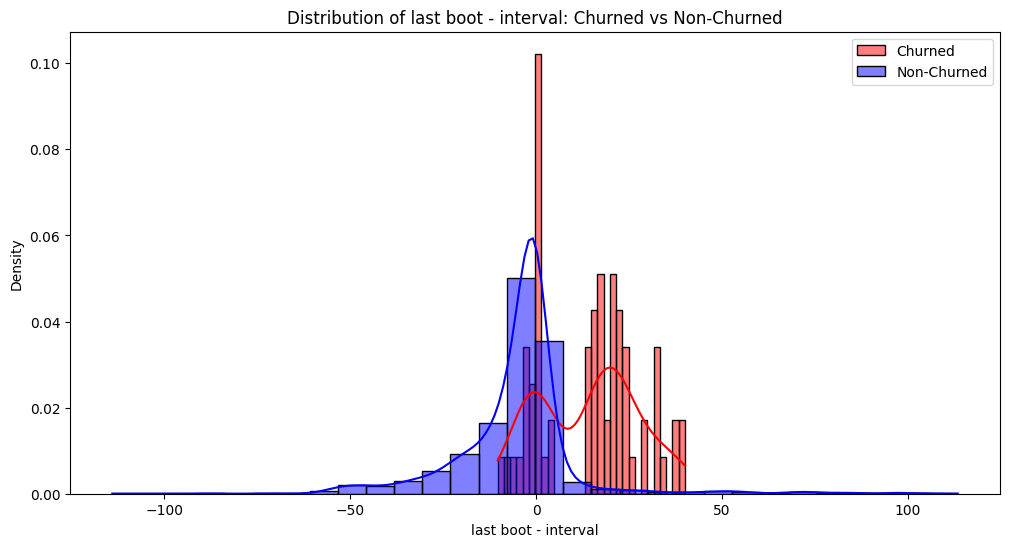

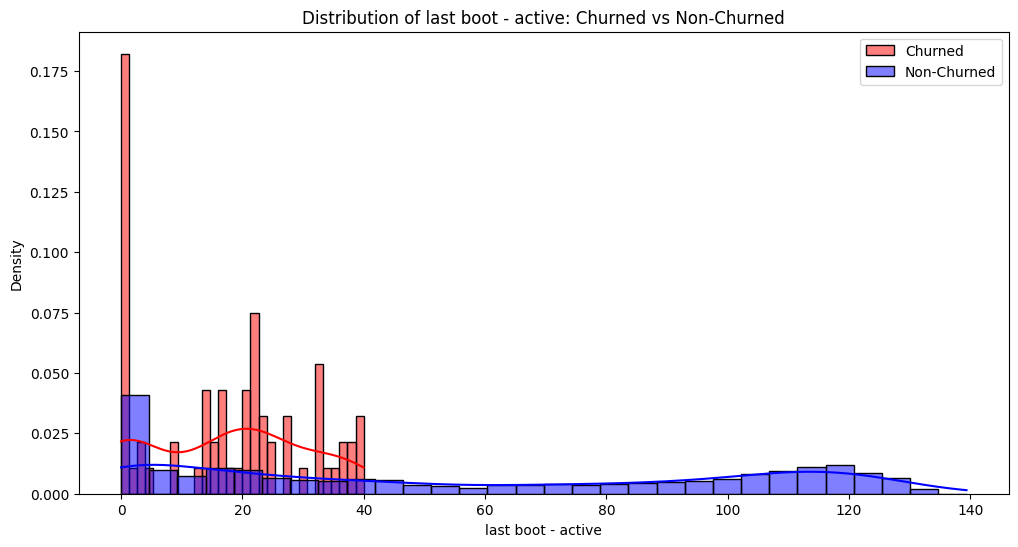

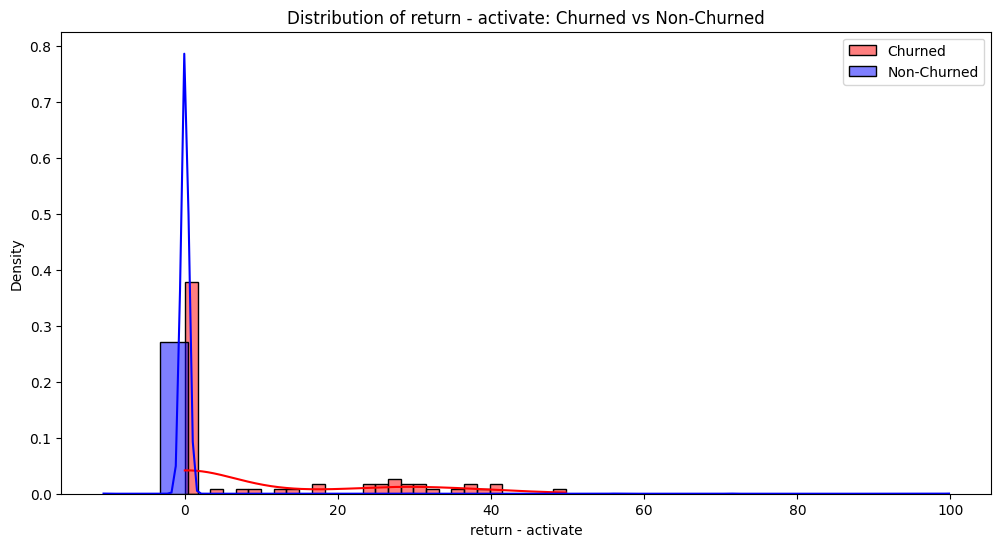

In [29]:
# Loop through each numerical feature and plot the distribution
for feature in numerical_features:
    plot_feature_distribution(b30_pro, feature, churned, non_churned)

In [27]:
for feature in numerical_features:
    t_stat, p_val = stats.ttest_ind(churned[feature], non_churned[feature], equal_var=False)
    print(f"T-test for '{feature}' p-value: {p_val}")

T-test for 'last boot - interval' p-value: 3.5534948409265625e-19
T-test for 'last boot - active' p-value: 7.625494852891254e-43
T-test for 'return - activate' p-value: 3.692385468617318e-07


From the T-tests, we can see that all of them are extremely small, which means that there is significant difference between churned & non-churned customers

Correlation with Churn Flag:
 Churn Flag              1.000000
return - activate       0.404630
last boot - interval    0.171179
last boot - active     -0.125439
Name: Churn Flag, dtype: float64


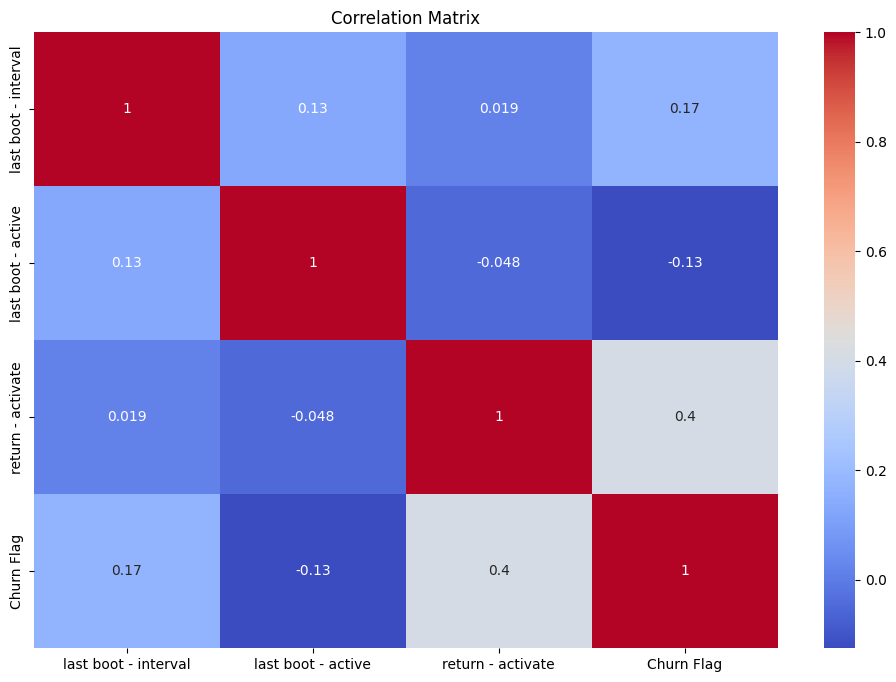

In [30]:
# Analyze correlation between numeric features and 'Churn Flag'
numeric_data = b30_pro.select_dtypes(include=['float64', 'int64'])
corr_with_churn = numeric_data.corr()['Churn Flag'].sort_values(ascending=False)
print("Correlation with Churn Flag:\n", corr_with_churn)

# Visualize the correlation matrix
corr_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()